In [1]:
import os
import gc
import sys
import json
import torch
import torch.nn.functional as F
import numpy as np
import pandas as pd
from tqdm import tqdm

from IPython.display import HTML, display
import matplotlib
import matplotlib.pyplot as plt
import plotly.express as px
from plotly.subplots import make_subplots
import plotly.graph_objects as go
from sklearn.manifold import TSNE

from transformer_lens import HookedTransformer
import transformer_lens.utils as tutils

from model import MLP
from utils import get_freqs, find_similar_decoder_weights, find_similar_encoder_weights
from buffer import Buffer
from config import Config

from datasets import load_dataset

from make_json import make_json, single_neuron, save_snippets_to_html, style_snippet

In [2]:
torch.set_grad_enabled(False)

In [3]:
# save_dir = "mlps/2023-11-26_17-53-28" # sunny hill. ReLU. l1 0.0002. <-- this is good. Main model.
save_dir = "mlps/2023-12-11_13-04-05" # deft dragon. Like sunny hill but no pre-bias.
# save_dir = "mlps/2023-12-13_10-35-07" # neat tree. like deft dragon but l1 0.0005.
# save_dir = "mlps/2023-12-14_15-45-04" # solar glitter. Like deft dragon but l1 0.0001

config = Config.from_json(file_path=os.path.join(save_dir, "cfg.json"))
config.device = 'mps'
print(config)
device = 'mps'

original_model = HookedTransformer.from_pretrained(config.original_model)
original_model.to(config.device)

Config(save_dir='mlps/2023-12-11_13-04-05', device='mps', original_model='tiny-stories-2L-33M', dataset='roneneldan/TinyStories', batch_size=1024, buffer_mult=384, num_tokens=4000000000, seq_len=128, layer_idx=1, in_hook='ln2.hook_normalized', out_hook='hook_mlp_out', lr=5e-05, l1_coeff=0.0002, l1_warmup=None, l1_sqrt=False, beta1=0.9, beta2=0.99, weight_decay=0.0001, d_hidden_mult=16, d_in=1024, act='relu', leq_renorm=True, add_pre_bias=False, renorm_to=1.0, per_neuron_coeff=False, model_batch_size=128, buffer_size=393216, buffer_batches=3072)
Loaded pretrained model tiny-stories-2L-33M into HookedTransformer
Moving model to device:  mps


HookedTransformer(
  (embed): Embed()
  (hook_embed): HookPoint()
  (pos_embed): PosEmbed()
  (hook_pos_embed): HookPoint()
  (blocks): ModuleList(
    (0-1): 2 x TransformerBlock(
      (ln1): LayerNormPre(
        (hook_scale): HookPoint()
        (hook_normalized): HookPoint()
      )
      (ln2): LayerNormPre(
        (hook_scale): HookPoint()
        (hook_normalized): HookPoint()
      )
      (attn): Attention(
        (hook_k): HookPoint()
        (hook_q): HookPoint()
        (hook_v): HookPoint()
        (hook_z): HookPoint()
        (hook_attn_scores): HookPoint()
        (hook_pattern): HookPoint()
        (hook_result): HookPoint()
      )
      (mlp): MLP(
        (hook_pre): HookPoint()
        (hook_post): HookPoint()
      )
      (hook_attn_in): HookPoint()
      (hook_q_input): HookPoint()
      (hook_k_input): HookPoint()
      (hook_v_input): HookPoint()
      (hook_mlp_in): HookPoint()
      (hook_attn_out): HookPoint()
      (hook_mlp_out): HookPoint()
      (hoo

In [4]:
################# Choose dataset ###########################
# data = load_dataset("NeelNanda/c4-code-20k", split="train")
data = load_dataset("roneneldan/TinyStories", split="validation")
############################################################

tokenized_data = tutils.tokenize_and_concatenate(data, original_model.tokenizer, max_length=128)
tokenized_data = tokenized_data.shuffle(42)
all_tokens = tokenized_data["tokens"]

Repo card metadata block was not found. Setting CardData to empty.
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
/Users/slava/safety/ft_exp/.venv/lib/python3.9/site-packages/datasets/table.py:1421: FutureWarning: promote has been superseded by mode='default'.
  table = cls._concat_blocks(blocks, axis=0)


In [5]:
# buffer = Buffer(cfg=config, model=original_model, device=config.device)

model_path = os.path.join(save_dir, "mlp_final.pt")


model = MLP(cfg=config)
model.load_state_dict(torch.load(model_path, map_location=config.device))
model.eval()
model.to(config.device)

MLP(
  (act): ReLU()
)

In [6]:
# compare decoder to original
A = model.W_dec.detach().cpu() 
B = original_model.blocks[config.layer_idx].mlp.W_out.detach().cpu() 

A = torch.nn.functional.normalize(A, p=2, dim=1)
B = torch.nn.functional.normalize(B, p=2, dim=1)

# Compute cosine similarity for the original A
cosine_similarity = A @ B.T  # Shape: (16384, 4096)
max_similarities, most_similar_idxs = torch.max(cosine_similarity, dim=1)
hist_data_all = max_similarities.detach().flatten().numpy()

decoder_idxs_similar_to_orig = (max_similarities > 0.8).nonzero().squeeze(1)

print("similar idxs to orig: ", decoder_idxs_similar_to_orig[:10])

fig = px.histogram(hist_data_all, title="Decoder Similarity to Original", histnorm='percent', labels={'value': 'Cosine Similarity'})
# px.histogram(hist_data_all, title="Decoder Similarity to Original", histnorm='percent', labels={'value': 'Cosine Similarity'})
fig.update_layout(showlegend=False)
fig.show()

similar idxs to orig:  tensor([ 1,  2,  8, 10, 11, 15, 24, 28, 29, 30])


In [7]:
# compare encoder to original
A = model.W_enc.detach().cpu() # [1024, 16384]
B = original_model.blocks[config.layer_idx].mlp.W_in.detach().cpu() # [1024, 4096]

A = torch.nn.functional.normalize(A, p=2, dim=1)
B = torch.nn.functional.normalize(B, p=2, dim=1)

# Compute cosine similarity for the original A
cosine_similarity = A.T @ B  # Shape: (16384, 4096)
max_similarities, most_similar_idxs = torch.max(cosine_similarity, dim=1)
hist_data_all = max_similarities.detach().flatten().numpy()

A_top = A[:, decoder_idxs_similar_to_orig]

# Compute cosine similarity for the modified A
cosine_similarity_top = A_top.T @ B
print(cosine_similarity_top.shape)
max_similarities_top, most_similar_idxs_top = torch.max(cosine_similarity_top, dim=1)
print(max_similarities_top[:5])
hist_data_top = max_similarities_top.detach().flatten().numpy()

values = np.concatenate([hist_data_all, hist_data_top])
labels = ["All Features"] * len(hist_data_all) + ["Neuron Simulators"] * len(hist_data_top)

df = pd.DataFrame({
    "Cosine Similarity": values,
    "Feature Type": labels
})
px.histogram(df, title="Encoder Similarity to Original", x="Cosine Similarity", color="Feature Type", barmode='overlay')

torch.Size([4971, 4096])
tensor([0.1491, 0.1992, 0.2666, 0.0641, 0.1996])


In [8]:
decoder_idxs_similar_to_orig[:8]

tensor([ 1,  2,  8, 10, 11, 15, 24, 28])

In [9]:
# get variance along vector

def get_all_projections(along, num_batches=5, batch_size=256, silent=False, custom_hook_point=None, pre_bias=None, bias=None):
    if custom_hook_point is None:
        custom_hook_point = config.in_hook
    if pre_bias is None:
        pre_bias = torch.zeros(1024, device=config.device)
    if bias is None:
        bias = 0
        
    along = along.to(config.device)
    all_projections = []

    for i in tqdm(range(num_batches), disable=silent):
        tokens = all_tokens[i*batch_size:(i+1)*batch_size]

        _, cache = original_model.run_with_cache(tokens, stop_at_layer=config.layer_idx + 1,
                                                 names_filter=f"blocks.{config.layer_idx}.{custom_hook_point}")
        mlp_acts = cache[f"blocks.{config.layer_idx}.{custom_hook_point}"]
        mlp_acts = mlp_acts.reshape(-1, config.d_in)
        
        mlp_acts = mlp_acts + pre_bias

        # mlp_acts is [128*batch_size, 1024]
        # project
        projections = mlp_acts @ along
        projections = projections + bias
        all_projections.append(projections)

    all_projections = torch.cat(all_projections).cpu()
    return all_projections
    

def compute_var(along, num_batches=5, batch_size=256, silent=False, plot=False, custom_hook_point=None, pre_bias=None, bias=None):
    all_projections = get_all_projections(
        along=along,
        num_batches=num_batches,
        batch_size=batch_size,
        silent=silent,
        custom_hook_point=custom_hook_point,
        pre_bias=pre_bias,
        bias=bias,
    )
    if plot:
        fig = px.histogram(all_projections.cpu(), histnorm='percent')
        fig.show()
    
    return all_projections.var().item()


In [10]:

# onto encoder of Neuron Simulator #1 (has max encoder sim 0.1776) which seem representative
enc_idx = decoder_idxs_similar_to_orig[2]
proj_onto = model.W_enc.T[enc_idx]

compute_var(along=proj_onto)

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:01<00:00,  3.33it/s]


1.0288606882095337

In [11]:
# ft_variances = [compute_var(along=model.W_enc.T[i], silent=True) for i in range(20)]

# npv = np.array(ft_variances)
# print(decoder_idxs_similar_to_orig[:24])
# npv_simulators = npv[decoder_idxs_similar_to_orig[:3]] ### hack!!!


# values = np.concatenate([npv, npv_simulators])
# labels = ["All Features"] * len(npv) + ["Neuron Simulators"] * len(npv_simulators)

# df = pd.DataFrame({
#     "Value": values,
#     "DataSet": labels
# })
# px.histogram(df, title="Encoder", x="Value", color="DataSet", barmode='overlay')

In [12]:
# orig_variances = [compute_var(along=original_model.blocks[config.layer_idx].mlp.W_in.T[i], silent=True) for i in range(20)]
# px.histogram(orig_variances, nbins=20)

In [13]:
# compare encoder to original
A = model.W_enc.detach().cpu() # [1024, 16384]
B = original_model.blocks[config.layer_idx].mlp.W_in.detach().cpu() # [1024, 4096]

normed_A = torch.nn.functional.normalize(A, p=2, dim=1)
normed_B = torch.nn.functional.normalize(B, p=2, dim=1)

cosine_similarity = normed_A.T @ normed_B  # Shape: (16384, 4096)
max_similarities, most_similar_idxs = torch.max(cosine_similarity, dim=1)

# get a Neuron Simulator idx and vector
n_sim_idx = decoder_idxs_similar_to_orig[0] ###
n_sim_vec = A[:, n_sim_idx]

# get the matching Original vector
original_match_idx = most_similar_idxs[n_sim_idx]
original_match_vec = B[:, original_match_idx]

print('match idx', original_match_idx)
print('match sim', max_similarities[n_sim_idx])

# compute variance along each and along difference
diff_vec = n_sim_vec - original_match_vec
normed_diff = F.normalize(diff_vec, dim=0)

model_b_enc = model.b_enc[n_sim_idx]
original_b_enc = original_model.blocks[config.layer_idx].mlp.b_in[original_match_idx]
# print()
# print('var along a:          ', compute_var(along=n_sim_vec, silent=True, plot=True, pre_bias = model.b_pre, bias=model_b_enc))
# print('var along normed a:   ', compute_var(along=normed_A[:, n_sim_idx], silent=True, pre_bias = model.b_pre, bias=model_b_enc))
# print()
# print('var along b:          ', compute_var(along=original_match_vec, silent=True, plot=True, bias=original_b_enc))
# print('var along normed b:   ', compute_var(along=normed_B[:, n_sim_idx], silent=True, bias=original_b_enc))
# print()
# print('var along diff:       ', compute_var(along=diff_vec, silent=True, plot=True))
# print('var along normed diff:', compute_var(along=normed_diff, silent=True))

pa = get_all_projections(along=n_sim_vec, silent=True, pre_bias=model.b_pre, bias=model_b_enc, num_batches=1).numpy()
pb = get_all_projections(along=original_match_vec, silent=True, bias=original_b_enc, num_batches=1).numpy()

correlation_matrix = np.corrcoef(pa, pb)
correlation = correlation_matrix[0, 1]

print("Correlation Coefficient:", correlation)

# Fit a line of best fit
slope, intercept = np.polyfit(pb, pa, 1)
line_x = np.linspace(min(pb), max(pb), 100)
line_y = slope * line_x + intercept

print(f"y = {slope:.2f}x {'+' if intercept >= 0 else '-'} {abs(intercept):.2f}")


# Create scatter plot
scatter = go.Scatter(x=pb, y=pa, mode='markers', marker=dict(opacity=0.2), name="")
line = go.Scatter(x=line_x, y=line_y, mode='lines', name='Best Fit')

# Combine plots
fig = go.Figure(data=[scatter, line])
fig.update_layout(
    title="Correlation between Neuron and Neuron Simulator",
    xaxis_title="Original Neuron Activation",
    yaxis_title="GMLP Feature Activation",
    showlegend=False,
)

# Display the figure
fig.show()

match idx tensor(2955)
match sim tensor(0.1491)
Correlation Coefficient: 0.9859672990085687
y = 0.81x - 0.22


In [14]:
encoder_weights = model.W_enc.detach().cpu()  # shape [1024, 16384]

# Lengths for the weights at indices in decoder_idxs_similar_to_orig
encoder_weights_similar = encoder_weights[:, decoder_idxs_similar_to_orig]
lengths_similar = torch.norm(encoder_weights_similar, p=2, dim=0)

mask = torch.ones(encoder_weights.shape[1], dtype=bool)
mask[decoder_idxs_similar_to_orig] = False
enc_not_sim = encoder_weights[:, mask]

lengths_not_sim = torch.norm(enc_not_sim, p=2, dim=0)


values = torch.cat([lengths_similar, lengths_not_sim]).numpy()

labels = ["Neuron Simulators"] * len(lengths_similar) + ["Other"] * len(lengths_not_sim)
print(len(lengths_similar))
print(len(lengths_not_sim))

df = pd.DataFrame({
    "Length": values,
    "Category": labels
})

# Plot histogram
fig = px.histogram(df, title="Encoder Lengths", x="Length", color="Category", barmode='overlay')
fig.show()

4971
11413


In [15]:
def get_activation_means(num_batches=5, batch_size=256, silent=True):
    # for a model
    custom_hook_point = config.in_hook
    sums = torch.zeros(config.d_in*config.d_hidden_mult, device=device)

    for i in tqdm(range(num_batches), disable=silent):
        tokens = all_tokens[i*batch_size:(i+1)*batch_size]

        _, cache = original_model.run_with_cache(tokens, stop_at_layer=config.layer_idx + 1,
                                                 names_filter=f"blocks.{config.layer_idx}.{custom_hook_point}")
        in_vecs = cache[f"blocks.{config.layer_idx}.{custom_hook_point}"]
        in_vecs = in_vecs.reshape(-1, config.d_in)
        
        activations = model.encode(in_vecs)
        sums = sums + activations.sum(dim=0)
    sums = sums/(num_batches*batch_size*config.seq_len)
    return sums.cpu()

In [16]:
get_activation_means().shape

torch.Size([16384])

In [17]:
def mean_ablated_forward(idxs_to_ablate, num_batches=1, batch_size=256, silent=True, normalize=False, zero_ablate=False):
    custom_hook_point = config.in_hook
    idxs_to_ablate = idxs_to_ablate.to(device)
    if not zero_ablate:
        activation_means = get_activation_means().to(device) # shape is (hidden_dim,)
    
    diffs = 0

    for i in tqdm(range(num_batches), disable=silent):
        tokens = all_tokens[i*batch_size:(i+1)*batch_size]
        _, cache = original_model.run_with_cache(tokens, stop_at_layer=config.layer_idx + 1,
                                                 names_filter=f"blocks.{config.layer_idx}.{custom_hook_point}")
        in_vecs = cache[f"blocks.{config.layer_idx}.{custom_hook_point}"]
        in_vecs = in_vecs.reshape(-1, config.d_in)
        activations = model.encode(in_vecs)
        # activations is shape (batch_size, hidden_dim)
        
        if zero_ablate:
            activations[:, idxs_to_ablate] = 0
        else:
            activations[:, idxs_to_ablate] = activation_means[idxs_to_ablate]
            
        x_pred = activations @ model.W_dec + model.b_dec
        
        # get original model mlp out
        _, cache = original_model.run_with_cache(tokens, stop_at_layer=config.layer_idx + 1,
                                                 names_filter=f"blocks.{config.layer_idx}.{config.out_hook}")
        mlp_out = cache[f"blocks.{config.layer_idx}.{config.out_hook}"]
        mlp_out = mlp_out.reshape(-1, config.d_in)
        
        if normalize:
            x_pred = F.normalize(x_pred)
            mlp_out = F.normalize(mlp_out)

        d = torch.norm(x_pred - mlp_out, dim=1)

        diffs += d.sum().item()
    
    return diffs/(num_batches*batch_size*config.seq_len)
        
#         diffs += torch.norm(x_pred - x_true)
    
    


In [18]:
all_idxs = torch.arange(config.d_in*config.d_hidden_mult)
mask = torch.ones_like(all_idxs, dtype=bool)
mask[decoder_idxs_similar_to_orig] = False
other_idxs = all_idxs[mask]

In [19]:
print('original          ', mean_ablated_forward(torch.tensor(0)))
print()
print('ablate simulators ', mean_ablated_forward(decoder_idxs_similar_to_orig))
print('ablate others     ', mean_ablated_forward(other_idxs))
print('ablate all        ', mean_ablated_forward(torch.arange(config.d_in*config.d_hidden_mult)))
print()
print('zablate simulators ', mean_ablated_forward(decoder_idxs_similar_to_orig, zero_ablate=True))
print('zablate others     ', mean_ablated_forward(other_idxs, zero_ablate=True))
print('zablate all        ', mean_ablated_forward(torch.arange(config.d_in*config.d_hidden_mult), zero_ablate=True))

original           4.5225114822387695

ablate simulators  12.310707092285156
ablate others      11.082939147949219
ablate all         19.413999557495117

zablate simulators  12.724703788757324
zablate others      11.224356651306152
zablate all         19.97234344482422


In [20]:
# normalize l2 before computing error

print('original          ', mean_ablated_forward(torch.tensor(0), normalize=True))
print()
print('ablate simulators ', mean_ablated_forward(decoder_idxs_similar_to_orig, normalize=True))
print('ablate others     ', mean_ablated_forward(other_idxs, normalize=True))
print('ablate all        ', mean_ablated_forward(torch.arange(config.d_in*config.d_hidden_mult), normalize=True))
print()
print('zablate simulators ', mean_ablated_forward(decoder_idxs_similar_to_orig, zero_ablate=True, normalize=True))
print('zablate others     ', mean_ablated_forward(other_idxs, zero_ablate=True, normalize=True))
print('zablate all        ', mean_ablated_forward(torch.arange(config.d_in*config.d_hidden_mult), zero_ablate=True, normalize=True))


original           0.2229054570198059

ablate simulators  0.5653027296066284
ablate others      0.4782443046569824
ablate all         1.1925461292266846

zablate simulators  0.6089508533477783
zablate others      0.4729137420654297
zablate all         1.2669727802276611


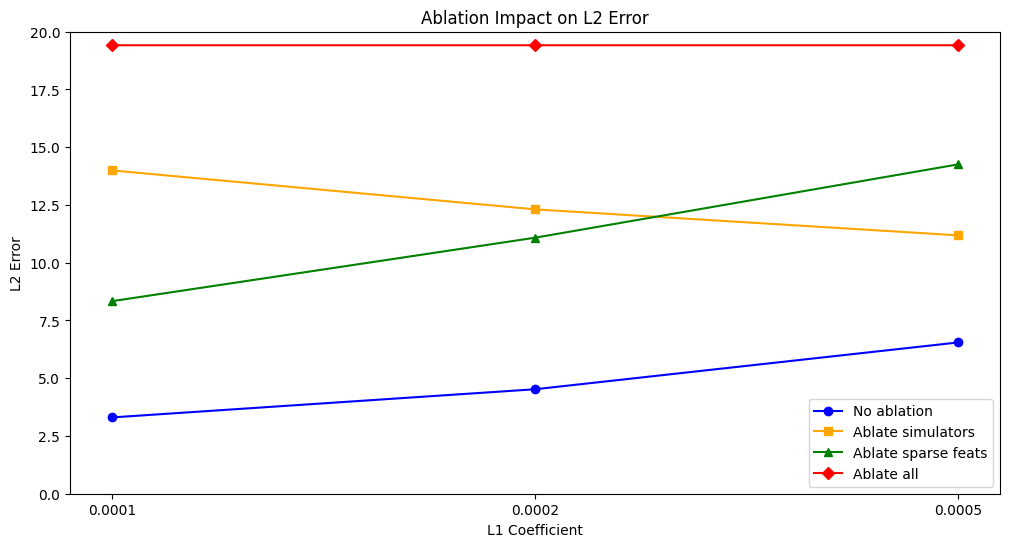

In [22]:
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D

# Data
ablations = ['No ablation', 'Ablate simulators', 'Ablate sparse feats', 'Ablate all']
solar_glitter = [3.30378866195679, 13.9942722320557, 8.33716201782227, 19.413969039917]
deft_dragon = [4.52251148223877, 12.3107070922852, 11.0829391479492, 19.4139995574951]
neat_tree = [6.54681396484375, 11.1857948303223, 14.2545261383057, 19.4140777587891]

# Colors and markers
colors = ['blue', 'orange', 'green', 'red']
markers = ['o', 's', '^', 'D']

# Create the plot
fig, ax = plt.subplots(figsize=(12, 6))

# Add each model's line
for i, ablation in enumerate(ablations):
    ax.plot(['0.0001', '0.0002', '0.0005'], 
            [solar_glitter[i], deft_dragon[i], neat_tree[i]],
            marker=markers[i], color=colors[i], label=ablation)

# Customize the plot
ax.set_title('Ablation Impact on L2 Error')
ax.set_xlabel('L1 Coefficient')
ax.set_ylabel('L2 Error')
ax.legend()

plt.ylim(0,20)

# Show the plot
plt.show()
